# Our final model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.1


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0


In [6]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.2.4-tf


## Loading and preparing our data set for classification
> Note: curl behind a firewall: `curl -x http://www-proxy.us.oracle.com:80 -O https://raw.githubusercontent...`

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0  72978      0 --:--:-- --:--:-- --:--:-- 72779


In [1]:
!cat ./insurance-customers-1500.csv | wc -l

    1501


In [12]:
!head ./insurance-customers-1500.csv

speed;age;miles;group
98.0;44.0;25.0;1
118.0;54.0;24.0;1
111.0;26.0;34.0;0
97.0;25.0;10.0;2
114.0;38.0;22.0;1
130.0;55.0;34.0;0
118.0;40.0;51.0;0
143.0;42.0;34.0;1
120.0;41.0;42.0;2


In [13]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']                                   # Isolate output data
df.drop('group', axis='columns', inplace=True)  # We drop the 'group' (last column, 0, 1, or 2) from the input data
X = df.as_matrix()

In [14]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [15]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000
std,17.604333,17.130400,15.250815
min,68.000000,16.000000,1.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,100.000000,84.000000


In [16]:
from sklearn.model_selection import train_test_split

Below, we split the data, into Training Data Set, and Test Data Set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [19]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [24]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

num_categories = 3
dropout = 0.6
# Define the model here
model = keras.Sequential()

model.add(Dense(100, name='hidden1', input_dim=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_categories, name='softmax', activation='softmax'))

# Compile it
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 100)               400       
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 100)               400       
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
__________

### We also limit the number of epochs further to 2000 (because we have seen that after that nothing good is going to happen)

Actual training happens right here:

In [25]:
BATCH_SIZE=1000
EPOCHS = 2000

%time history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

CPU times: user 38.8 s, sys: 6.85 s, total: 45.7 s
Wall time: 26.9 s


Now let's see how good the model is:

In [26]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 6us/sample - loss: 0.4886 - acc: 0.8078


(0.4886113703250885, 0.80777776)

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 6us/sample - loss: 0.5252 - acc: 0.7967


(0.5252487063407898, 0.7966667)

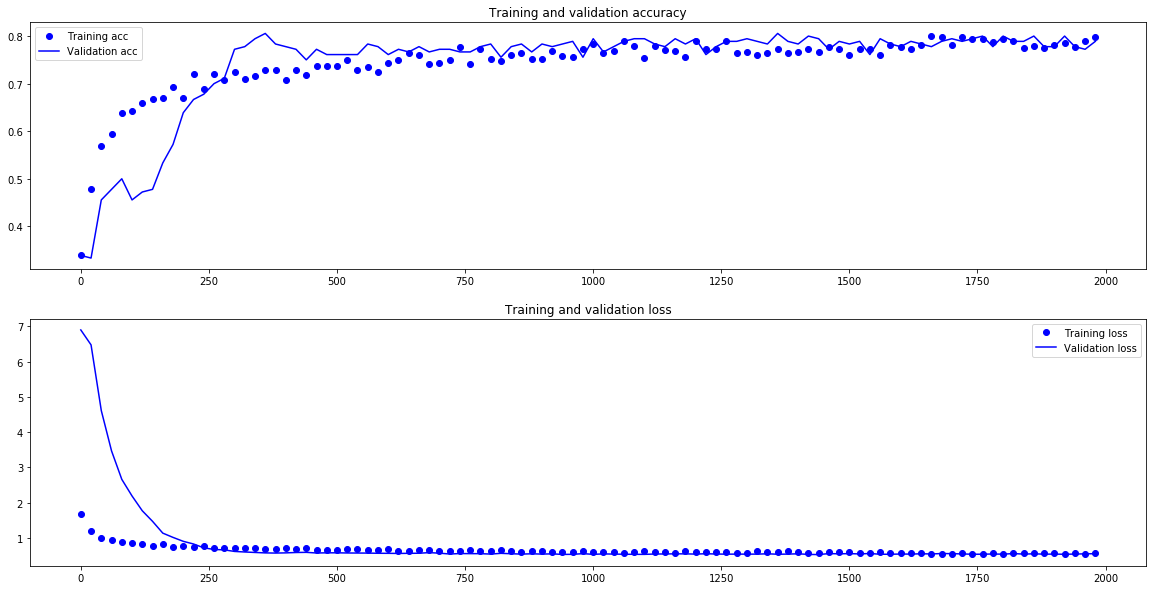

In [28]:
plot_history(history)

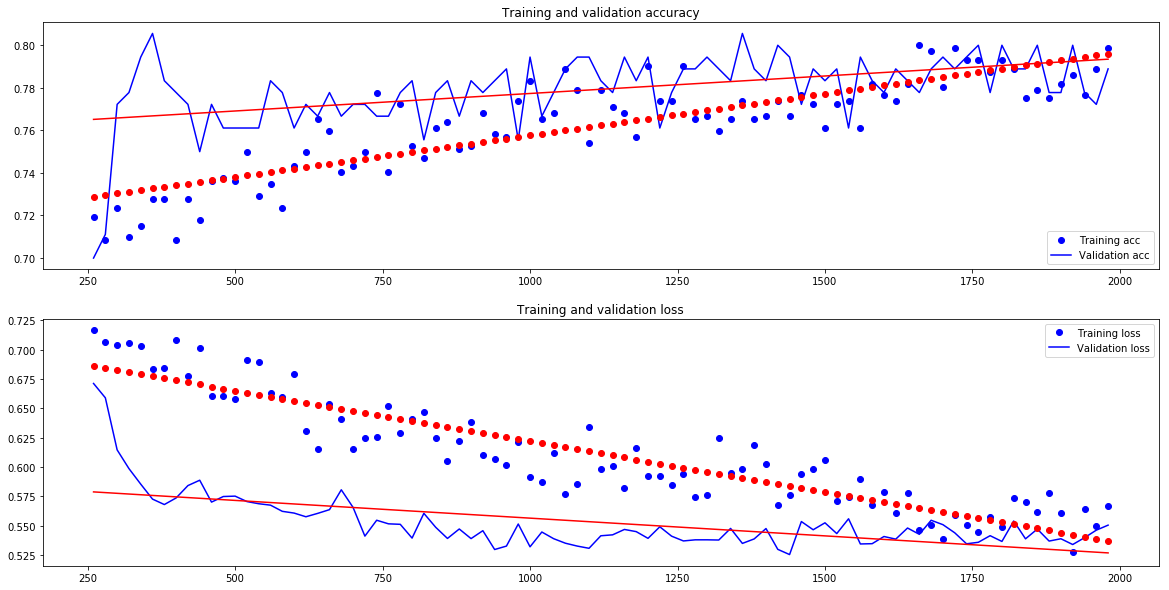

In [29]:
plot_history(history, init_phase_samples=250, plot_line=True)

### Scores around 80% look good now, there might even be a bit more potential here, but we are not going after a final percent here

## We now seem to have a decent model, so we save it for the next steps

In [30]:
model.save('insurance.h5')

In [31]:
# the model has a decent size as we only have a little more than 10.000 parameters
!ls -l insurance.h5

-rw-r--r--  1 olediour  staff  179840 Aug 24 10:57 insurance.h5
